<a href="https://colab.research.google.com/github/titikamon-k/DASD-5001-Project-NamJaThuamLaewKaiJaRot/blob/main/%E0%B8%99%E0%B9%89%E0%B8%B3%E0%B8%97%E0%B9%88%E0%B8%A7%E0%B8%A1%E0%B9%81%E0%B8%A5%E0%B9%89%E0%B8%A7%E0%B9%83%E0%B8%84%E0%B8%A3%E0%B8%88%E0%B8%B0%E0%B8%A3%E0%B8%AD%E0%B8%94_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mini Project: การหาจังหวัดเฝ้าระวังเสี่ยงน้ำท่วมจากข้อมูล ปริมาณน้ำฝน แนวร่องน้ำ และ พื้นที่น้ำท่วมซ้ำซากย้อนหลัง**

ข้อมูลที่ใช้ในการวิเคราะห์ หาจังหวัดเปราะบางที่เสี่ยงน้ำท่วมโดยวิเคราะห์จากข้อมูล:
1. ปริมาณน้ำฝน (mm) ย้อนหลังตั้งแต่ปี 2000 - 2025 จากข้อมูลของ Climate Hazards Group InfraRed Precipitation satellite imagery with insitu Station data (CHIRPS)
2. ข้อมูลจำนวนหมู่บ้าน ที่อยู่ในแนวร่องน้ำ อ่อนไหวต่อการเกิดภัยพิบัติ น้ำท่วม (flood) หากฝนตกหนัก จัดทำโดย www.mitrearth.org

3. ข้อมูลจำนวนตำบล และ พื้นที่ (ไร่) ที่เกิดน้ำท่วมซ้ำซากใน 10 ปีนี้ ท่วม 8-10 ครั้ง (2015-2025)


# Part 0:ติดตั้ง/โหลดข้อมูลจาก Google Drive -> tables

In [1]:
# =========================================
# 0) ติดตั้ง/โหลดข้อมูลจาก Google Drive -> tables
# =========================================
# !pip install gdown

import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from pathlib import Path
from typing import Dict, List, Sequence, Tuple

pd.options.display.float_format = "{:.2f}".format

# ---------- helper ดาวน์โหลด ----------
def load_csv_from_gdrive(file_id: str, filename: str, out_dir: str = ".") -> pd.DataFrame | None:
    """
    ดาวน์โหลดไฟล์จาก Google Drive (file_id) แล้วอ่านเป็น DataFrame
    คืนค่า DataFrame ถ้าสำเร็จ หรือ None ถ้าล้มเหลว
    """
    url = f"https://drive.google.com/uc?id={file_id}"
    out_path = Path(out_dir) / filename
    try:
        gdown.download(url, str(out_path), quiet=True)
        return pd.read_csv(out_path)
    except Exception as e:
        print(f"⚠️ โหลดไฟล์ {filename} ไม่สำเร็จ: {e}")
        return None

# ---------- รายชื่อไฟล์ ----------
files_info: Dict[str, str] = {
    "1jHwYpKT3zcTmoEeYpaXZhd_qFuVGFM7g": "rainfall_cleanes_2000.csv",
    "171mBRx5WZkgAwmYtyLRCxfcwdiZJD2tl": "PCODE_TH_with_region.csv",
    "1ng2y96j8dVygj1pEsXO-olJQ01R5-C-V": "Flood_Susceptible.csv",
    "1UVMXe7gkdxs4I-FTg237csePbiTJQNlm": "cleaned_sumflood.csv",
}

# ---------- โหลดไฟล์ทั้งหมดเข้า tables ----------
tables: Dict[str, pd.DataFrame] = {
    fname: df
    for fid, fname in files_info.items()
    if (df := load_csv_from_gdrive(fid, fname)) is not None
}

print("\n📂 ไฟล์ที่โหลดเข้ามาเรียบร้อย:")
if tables:
    for i, fname in enumerate(tables.keys(), start=1):
        print(f"- [{i}] {fname}")
else:
    print("ไม่มีไฟล์ที่โหลดได้")



📂 ไฟล์ที่โหลดเข้ามาเรียบร้อย:
- [1] rainfall_cleanes_2000.csv
- [2] PCODE_TH_with_region.csv
- [3] Flood_Susceptible.csv
- [4] cleaned_sumflood.csv


# Part 1:Utilities (ทำความสะอาด/ช่วยงาน)

In [2]:
# =========================================
# 1) Utilities (ทำความสะอาด/ช่วยงาน)
# =========================================
_NULL_LIKE = {"nan", "none", "null", ""}

def minmax_norm(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce").fillna(0.0)
    mn, mx = float(s.min()), float(s.max())
    return (s - mn) / (mx - mn) if mx > mn else pd.Series(0.0, index=s.index, dtype="float64")

def sanitize_names(s: pd.Series) -> pd.Series:
    s = s.astype("string").str.strip()
    return s.mask(s.isna() | s.eq("") | s.str.lower().isin(_NULL_LIKE), "(Unknown)")

def clean_key(df: pd.DataFrame, col: str) -> pd.DataFrame:
    out = df.copy()
    if col not in out.columns:
        out[col] = pd.NA
    s = out[col].astype("string").str.strip()
    s = s.mask(s.isna() | s.eq("") | s.str.lower().isin(_NULL_LIKE), pd.NA)
    out[col] = s
    return out

def _coalesce_columns(df: pd.DataFrame, mapping: Dict[str, List[str]]) -> pd.DataFrame:
    out = df.copy()
    ren = {}
    for target, aliases in mapping.items():
        if target in out.columns:
            continue
        for cand in aliases:
            if cand in out.columns:
                ren[cand] = target
                break
    return out.rename(columns=ren)

def compress_to_ranges(month_list: Sequence[int | str]) -> List[str]:
    """เชื่อมเดือนติดกันเป็นช่วง เช่น [5,6,7,9,10] -> ['5-7','9-10']"""
    if not month_list:
        return []
    nums = sorted(int(m) for m in month_list)
    ranges: List[Tuple[int, int]] = []
    start = prev = nums[0]
    for m in nums[1:]:
        if m == prev + 1:
            prev = m
        else:
            ranges.append((start, prev))
            start = prev = m
    ranges.append((start, prev))
    return [f"{a}" if a == b else f"{a}-{b}" for a, b in ranges]


# ===== Figure caption helper =====
# ===== Figure caption helper (auto bottom margin) =====
FIG_NUM = 1  # ลำดับรูปอัตโนมัติ

def add_caption(obj, text: str, bottom: float | None = None, loc: str = "left"):
    """
    วาง 'Figure N: ...' นอกกราฟด้านล่าง และปรับ margin ล่างอัตโนมัติให้ไม่ทับ tick labels
    - obj: fig หรือ ax
    - text: เนื้อหาแคปชัน
    - bottom: กำหนด margin ล่างเอง (0..1). ถ้าไม่ระบุจะคำนวณให้อัตโนมัติ
    - loc: 'left' หรือ 'right' สำหรับตำแหน่งชิดซ้าย/ขวา
    """
    global FIG_NUM
    fig = obj.get_figure() if hasattr(obj, "get_figure") else obj

    # รวบรวมข้อมูล tick labels เพื่อประเมินพื้นที่ที่ต้องใช้
    xticks = []
    max_rot = 0
    max_len = 0
    for ax in fig.axes:
        for t in ax.get_xticklabels():
            if t.get_visible():
                txt = t.get_text() or ""
                xticks.append(txt)
                max_len = max(max_len, len(txt))
                try:
                    max_rot = max(max_rot, abs(float(t.get_rotation() or 0)))
                except Exception:
                    pass

    # คำนวณ bottom margin แบบ heuristic
    if bottom is None:
        base = 0.18
        # ถ้า label ยาว เพิ่ม margin ตามความยาว (สูงสุด ~0.08)
        base += min(0.01 * (max_len / 10.0), 0.08)
        # ถ้ามีการเอียง label มาก เพิ่มอีก
        if max_rot >= 20:
            base += 0.10
        # ถ้ารูปเตี้ย (figheight < 4) เพิ่มอีกนิด
        if fig.get_figheight() < 4:
            base += 0.06
        # clamp
        bottom = min(max(base, 0.18), 0.40)

    # จัด layout + สำรองพื้นที่ล่าง
    try:
        fig.tight_layout()
    except Exception:
        pass
    fig.subplots_adjust(bottom=bottom)

    x = 0.01 if loc == "left" else 0.99
    ha = "left" if loc == "left" else "right"
    # วาง caption ใต้พื้นที่แกนลงมาเล็กน้อย (คงที่ 0.01 ปกติจะไม่ทับ)
    fig.text(x, 0.01, f"Figure {FIG_NUM}: {text}", ha=ha, va="bottom", fontsize=10)
    FIG_NUM += 1


## Part 1.1: All tables

In [3]:
from IPython.display import display

# วน loop แสดงตัวอย่างข้อมูล 5 แถวแรกจากทุกตาราง
for fname, df in tables.items():
    print(f"\n📌 ตัวอย่างจากไฟล์: {fname} | shape={df.shape}")
    display(df.head(5))   # โชว์ 5 แถวแรกแบบตาราง



📌 ตัวอย่างจากไฟล์: rainfall_cleanes_2000.csv | shape=(803250, 22)


,Unnamed: 0,date,adm_level,adm_id,PCODE_SUB,PCODE,ADM1_EN,Region_EN,n_pixels,rfh,...,r1h_avg,r3h,r3h_avg,rfq,r1q,r3q,version,Year,Month,Day
0,684,01-Jan-00,1,2851,TH37,TH37,Amnat Charoen,Eastnorth,106,0.16,...,1.77,94.50,63.86,100.62,105.42,144.49,final,2000,1,1
1,685,11-Jan-00,1,2851,TH37,TH37,Amnat Charoen,Eastnorth,106,0.07,...,0.93,68.99,37.74,100.04,96.67,173.10,final,2000,1,11
2,686,21-Jan-00,1,2851,TH37,TH37,Amnat Charoen,Eastnorth,106,2.10,...,1.18,39.84,22.09,118.61,118.58,165.51,final,2000,1,21
3,687,01-Feb-00,1,2851,TH37,TH37,Amnat Charoen,Eastnorth,106,4.83,...,5.57,18.57,16.48,103.29,113.53,109.70,final,2000,2,1
4,688,11-Feb-00,1,2851,TH37,TH37,Amnat Charoen,Eastnorth,106,5.25,...,10.72,19.04,17.69,100.28,109.27,105.95,final,2000,2,11



📌 ตัวอย่างจากไฟล์: PCODE_TH_with_region.csv | shape=(77, 5)


,ADM1_EN,ADM1_TH,PCODE,Region_TH,Region_EN
0,Bangkok,กรุงเทพมหานคร,TH10,ภาคกลาง,Central
1,Samut Prakan,สมุทรปราการ,TH11,ภาคกลาง,Central
2,Nonthaburi,นนทบุรี,TH12,ภาคกลาง,Central
3,Pathum Thani,ปทุมธานี,TH13,ภาคกลาง,Central
4,Phra Nakhon Si Ayutthaya,พระนครศรีอยุธยา,TH14,ภาคกลาง,Central



📌 ตัวอย่างจากไฟล์: Flood_Susceptible.csv | shape=(77, 4)


,ProvinceTh,ProvinceEn,PCODE,Flood_Susceptible
0,กระบี่,Krabi,TH81,392
1,ฉะเชิงเทรา,Chachoengsao,TH24,812
2,ชลบุรี,Chon Buri,TH20,754
3,ชัยนาท,Chai Nat,TH18,425
4,ชัยภูมิ,Chaiyaphum,TH36,1298



📌 ตัวอย่างจากไฟล์: cleaned_sumflood.csv | shape=(76, 7)


,ADM1_NAME,PCODE,NumFlood_8to10,NumFlood_4to7,NumFlood_lt3,Area_rai,เนื้อที่ (ตร.ม.)
0,Amnat Charoen,TH37,7.00,43.00,29.00,74407.00,119051200
1,Ang Thong,TH15,39.00,73.00,73.00,341259.00,546014400
2,Bangkok,TH10,0.00,38.00,25.00,165431.00,264689600
3,Bueng Kan,TH38,8.00,49.00,33.00,137829.00,220526400
4,Buri Ram,TH31,0.00,156.00,87.00,261837.00,418939200


# Part 2:อ้างอิงจังหวัด/ภาค (ref) + ฟังก์ชันช่วย

In [4]:
# =========================================
# 2) อ้างอิงจังหวัด/ภาค (ref) + ฟังก์ชันช่วย
# =========================================
def build_ref(tables: dict[str, pd.DataFrame]) -> pd.DataFrame:
    ref = tables["PCODE_TH_with_region.csv"].copy()
    ref = ref.rename(columns={"ADM1_PCODE": "PCODE", "ADM1_NAME": "ADM1_EN"})
    if "Region_EN" not in ref.columns:
        for alt in ("REGION_EN", "Region"):
            if alt in ref.columns:
                ref = ref.rename(columns={alt: "Region_EN"})
                break
    need = {"PCODE", "ADM1_EN", "Region_EN"}
    missing = need - set(ref.columns)
    if missing:
        raise RuntimeError(f"[ref] missing required columns: {sorted(missing)}")
    for c in ["PCODE", "ADM1_EN", "Region_EN"]:
        ref[c] = ref[c].astype("string").str.strip()
    return ref[["PCODE", "ADM1_EN", "Region_EN"]].drop_duplicates()

def sum_by_pcode(
    df: pd.DataFrame,
    value_col: str,
    ref: pd.DataFrame,
    pcode_col: str = "PCODE",
    name_col: str = "ADM1_EN",
    rename_map: dict | None = None,
) -> pd.DataFrame:
    """
    รวมค่าคอลัมน์ value_col ต่อ PCODE
    - ถ้ามี PCODE อยู่แล้ว: groupby โดยตรง
    - ถ้าไม่มี: map จากชื่อจังหวัด (ADM1_EN) ด้วย ref
    """
    d = df.copy()
    if rename_map:
        d = d.rename(columns=rename_map)
    if pcode_col in d.columns:
        d[pcode_col] = d[pcode_col].astype("string").str.strip()
        out = d.groupby(pcode_col, as_index=False)[value_col].sum()
    else:
        d = clean_key(d, name_col)
        out = (
            d.merge(ref[[name_col, pcode_col]], on=name_col, how="left")
             .groupby(pcode_col, as_index=False)[value_col].sum()
        )
    out[pcode_col] = out[pcode_col].astype("string").str.strip()
    return out

# Part 3: Rainfall: แนบ Region_EN + monthly_avg + วิเคราะห์มรสุม

## Part 3.1: เตรียมข้อมูล Rainfall

In [5]:
# =========================================
# 3) Rainfall: แนบ Region_EN + monthly_avg + วิเคราะห์มรสุม
# =========================================
ref = build_ref(tables)

# เตรียม rainfall ให้มีคอลัมน์มาตรฐาน
rain = tables["rainfall_cleanes_2000.csv"].copy()
rain = _coalesce_columns(rain, {
    "PCODE":   ["ADM1_PCODE", "adm1_pcode", "P_CODE"],
    "ADM1_EN": ["ADM1_NAME", "Province", "ADM1"],
    "Month":   ["month", "MONTH", "MonthNum", "Mon"],
    "rfh":     ["RFH", "rf", "rain", "Rainfall", "RAIN"],
})

# ถ้าไม่มี PCODE ให้ map จาก ADM1_EN
if "PCODE" not in rain.columns:
    if "ADM1_EN" not in rain.columns:
        raise RuntimeError("[rainfall] Neither PCODE nor ADM1_EN present to map PCODE.")
    rain["ADM1_EN"] = rain["ADM1_EN"].astype("string").str.strip()
    rain = rain.merge(ref[["ADM1_EN", "PCODE"]], on="ADM1_EN", how="left")

# จัดชนิดข้อมูล
rain["PCODE"] = rain["PCODE"].astype("string").str.strip()
if "ADM1_EN" in rain.columns:
    rain["ADM1_EN"] = rain["ADM1_EN"].astype("string").str.strip()
if "Month" not in rain.columns:
    raise RuntimeError("[rainfall] missing Month column after coalescing.")
if "rfh" not in rain.columns:
    raise RuntimeError("[rainfall] missing rfh column after coalescing.")
rain["Month"] = pd.to_numeric(rain["Month"], errors="coerce").astype("Int64")
rain["rfh"]   = pd.to_numeric(rain["rfh"], errors="coerce").fillna(0.0)

# แนบ Region_EN/ADM1_EN จาก ref (เชื่อถือ PCODE เป็นหลัก)
rain2 = rain.merge(ref[["PCODE", "ADM1_EN", "Region_EN"]], on="PCODE", how="left", suffixes=("", "_ref"))
if "ADM1_EN_ref" in rain2.columns:
    rain2["ADM1_EN"] = rain2["ADM1_EN_ref"].fillna(rain2.get("ADM1_EN"))
    rain2 = rain2.drop(columns=["ADM1_EN_ref"])

# ตรวจ Region_EN
if rain2["Region_EN"].isna().any():
    # fallback ด้วยชื่อจังหวัด
    mask = rain2["Region_EN"].isna() & rain2["ADM1_EN"].notna()
    if mask.any():
        fill = rain2.loc[mask, ["ADM1_EN"]].merge(ref[["ADM1_EN", "Region_EN"]], on="ADM1_EN", how="left")["Region_EN"]
        rain2.loc[mask, "Region_EN"] = fill.values
if rain2["Region_EN"].isna().any():
    miss = int(rain2["Region_EN"].isna().sum())
    sample = rain2.loc[rain2["Region_EN"].isna(), ["PCODE", "ADM1_EN", "Month"]].head(10)
    raise RuntimeError(f"[rainfall] Region_EN still missing for {miss} rows.\nSample:\n{sample}")

rain2["Region_EN"] = rain2["Region_EN"].replace("Eastnorth","Northeast")

# monthly_avg (Region_EN, ADM1_EN, Month, rfh)
monthly_avg = (
    rain2.groupby(["Region_EN", "ADM1_EN", "Month"], as_index=False)["rfh"]
         .mean()
)
print("monthly_avg ready:", monthly_avg.shape)
display(monthly_avg.head(10))

# ---------- วิเคราะห์มรสุม (จังหวัด/ภาค) ----------
def month_name_map(n): return calendar.month_name[int(n)] if pd.notna(n) else ""
def month_abbr_map(n): return calendar.month_abbr[int(n)] if pd.notna(n) else ""

mavg = monthly_avg.copy()
mavg["Month_Name"] = mavg["Month"].map(month_name_map)

# จังหวัด: เลือกเดือน rfh สูงสุด (tie-break ด้วยเดือนเลขน้อยสุด)
prov_monsoon = (
    mavg.sort_values(["Region_EN", "ADM1_EN", "rfh", "Month"], ascending=[True, True, False, True])
        .drop_duplicates(subset=["Region_EN", "ADM1_EN"], keep="first")
        .loc[:, ["Region_EN", "ADM1_EN", "Month", "Month_Name", "rfh"]]
        .reset_index(drop=True)
)
print("📌 Monsoon month per province (sample):")
display(prov_monsoon.head(20))

monthly_avg ready: (924, 4)


,Region_EN,ADM1_EN,Month,rfh
0,Central,Ang Thong,1,1.56
1,Central,Ang Thong,2,6.19
2,Central,Ang Thong,3,13.05
3,Central,Ang Thong,4,27.55
4,Central,Ang Thong,5,47.39
5,Central,Ang Thong,6,45.05
6,Central,Ang Thong,7,46.48
7,Central,Ang Thong,8,56.25
8,Central,Ang Thong,9,89.87
9,Central,Ang Thong,10,54.98


📌 Monsoon month per province (sample):


,Region_EN,ADM1_EN,Month,Month_Name,rfh
0,Central,Ang Thong,9,September,89.87
1,Central,Bangkok,9,September,101.25
2,Central,Chai Nat,9,September,103.16
3,Central,Lop Buri,9,September,93.14
4,Central,Nakhon Nayok,9,September,100.89
5,Central,Nakhon Pathom,9,September,89.04
6,Central,Nonthaburi,9,September,95.45
7,Central,Pathum Thani,9,September,92.01
8,Central,Phra Nakhon Si Ayutthaya,9,September,90.73
9,Central,Samut Prakan,9,September,101.43


## Part 3.2: วิเคราะห์มรสุม(ภาค)

📌 Monsoon month for each Region:


,Region_EN,Month,Month_Name,rfh
0,Central,9,September,94.12
1,East,9,September,122.73
2,North,9,September,92.26
3,Northeast,8,August,102.32
4,South,11,November,122.38
5,West,9,September,82.59


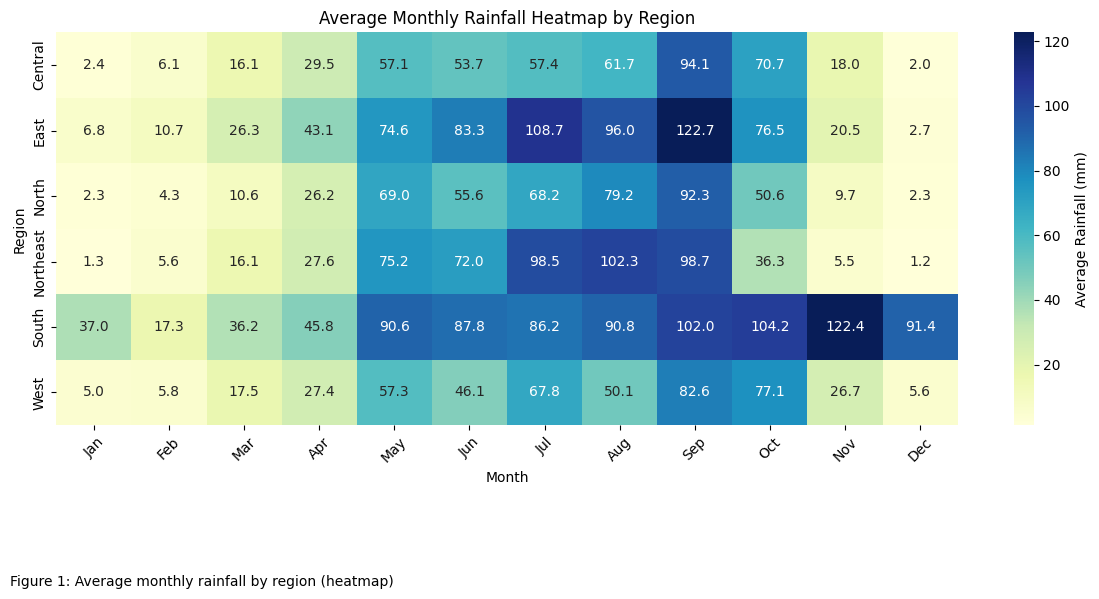

In [6]:
# ภาค-เดือนเฉลี่ย
region_monthly = (
    mavg.groupby(["Region_EN", "Month"], as_index=False)["rfh"]
        .mean()
)
region_monthly["Month_Name"] = region_monthly["Month"].map(month_name_map)

# ภาคมรสุม (tie-break เดือนเลขน้อยสุด)
region_monsoon = (
    region_monthly.sort_values(["Region_EN", "rfh", "Month"], ascending=[True, False, True])
                  .drop_duplicates(subset=["Region_EN"], keep="first")
                  .loc[:, ["Region_EN", "Month", "Month_Name", "rfh"]]
                  .reset_index(drop=True)
)
print("📌 Monsoon month for each Region:")
display(region_monsoon)

# ---------- กราฟรวมระดับภาค ----------


heatmap_data = (
    region_monthly.pivot(index="Region_EN", columns="Month", values="rfh")
                  .reindex(columns=range(1, 13))
)
plt.figure(figsize=(12, 6))
ax = sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu",
                 cbar_kws={'label': 'Average Rainfall (mm)'})
ax.set_title("Average Monthly Rainfall Heatmap by Region")
ax.set_xlabel("Month"); ax.set_ylabel("Region")
ax.set_xticklabels([calendar.month_abbr[i] for i in heatmap_data.columns], rotation=45)
plt.tight_layout()
add_caption(plt.gcf(), "Average monthly rainfall by region (heatmap)")
plt.show()


📌 ปีล่าสุดในข้อมูล: 2025


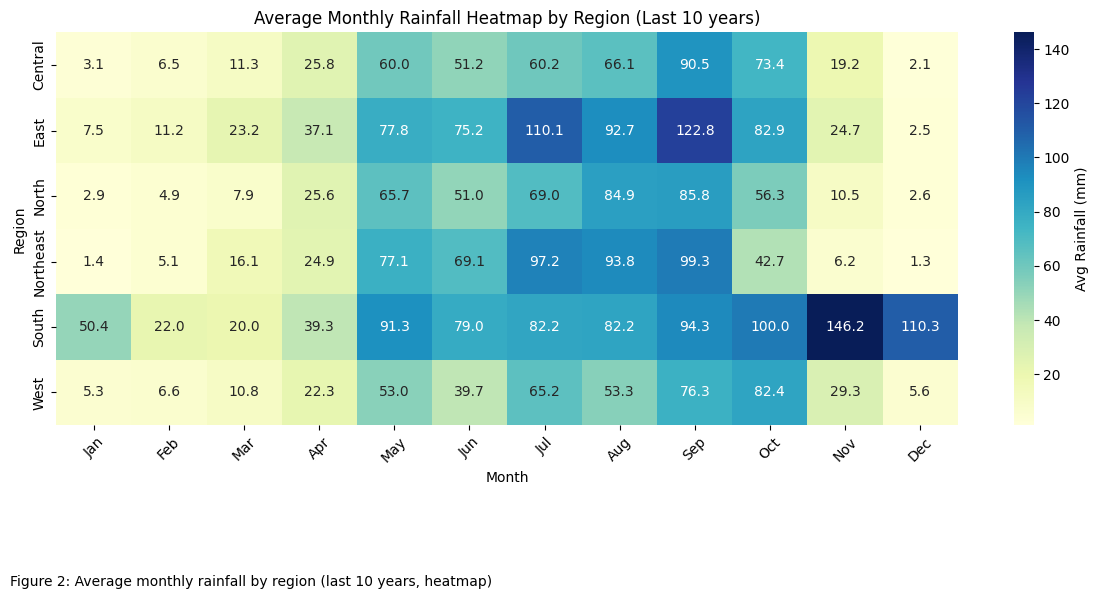

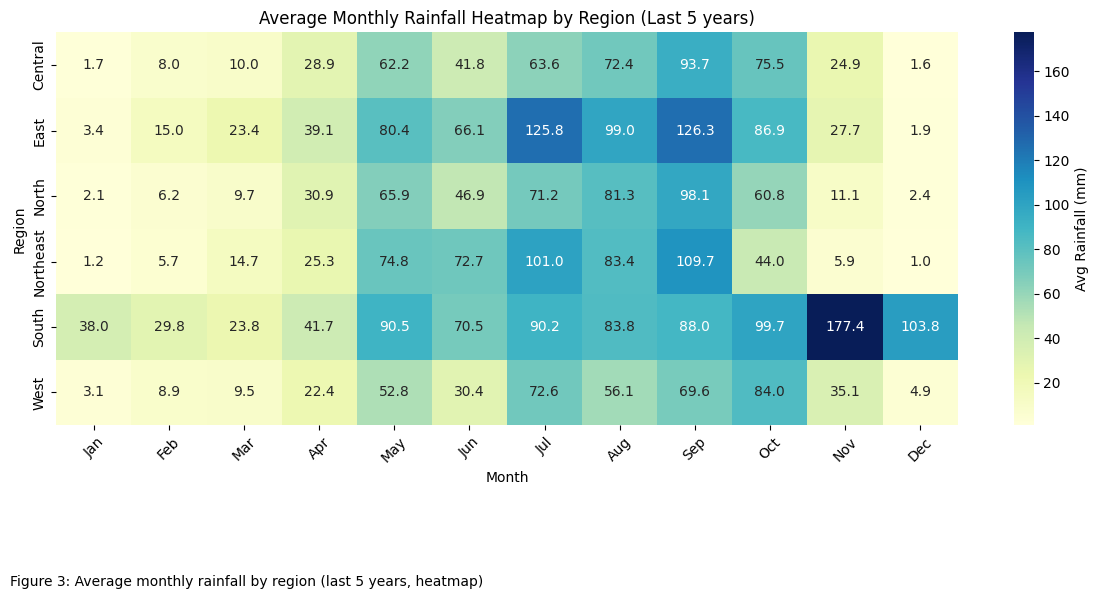

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

# ==========================
# ฟังก์ชันช่วย: ทำ region_monthly สำหรับช่วงปี
# ==========================
def build_region_monthly(rain_df: pd.DataFrame, start_year: int, end_year: int) -> pd.DataFrame:
    if "Year" not in rain_df.columns:
        raise RuntimeError("❌ rain_df ไม่มีคอลัมน์ Year ต้องสร้าง Year จาก Date ก่อนครับ")
    df = rain_df[(rain_df["Year"] >= start_year) & (rain_df["Year"] <= end_year)].copy()
    reg_mon = (
        df.groupby(["Region_EN", "Month"], as_index=False)["rfh"]
          .mean()
    )
    reg_mon["Month_Name"] = reg_mon["Month"].map(lambda n: calendar.month_name[int(n)] if pd.notna(n) else "")
    return reg_mon


# ==========================
# ฟังก์ชันช่วย: ทำ region_monthly สำหรับช่วงปี
# ==========================
def build_region_monthly(rain_df: pd.DataFrame, start_year: int, end_year: int) -> pd.DataFrame:
    df = rain_df[(rain_df["Year"] >= start_year) & (rain_df["Year"] <= end_year)].copy()
    reg_mon = (
        df.groupby(["Region_EN", "Month"], as_index=False)["rfh"]
          .mean()
    )
    reg_mon["Month_Name"] = reg_mon["Month"].map(month_name_map)
    return reg_mon

# ==========================
# หาปีล่าสุดในข้อมูล
# ==========================
latest_year = int(rain2["Year"].max())
print("📌 ปีล่าสุดในข้อมูล:", latest_year)

# กำหนดช่วง
region_monthly_10y = build_region_monthly(rain2, latest_year-9, latest_year)
region_monthly_5y  = build_region_monthly(rain2, latest_year-4, latest_year)


# ==========================
# Heatmap 10 ปี
# ==========================
heatmap_data_10y = (
    region_monthly_10y.pivot(index="Region_EN", columns="Month", values="rfh")
                      .reindex(columns=range(1,13))
)
plt.figure(figsize=(12,6))
ax = sns.heatmap(heatmap_data_10y, annot=True, fmt=".1f", cmap="YlGnBu",
                 cbar_kws={'label': 'Avg Rainfall (mm)'})
ax.set_title("Average Monthly Rainfall Heatmap by Region (Last 10 years)")
ax.set_xlabel("Month"); ax.set_ylabel("Region")
ax.set_xticklabels([calendar.month_abbr[i] for i in heatmap_data_10y.columns], rotation=45)
plt.tight_layout()
add_caption(plt.gcf(), "Average monthly rainfall by region (last 10 years, heatmap)")
plt.show()

# ==========================
# Heatmap 5 ปี
# ==========================
heatmap_data_5y = (
    region_monthly_5y.pivot(index="Region_EN", columns="Month", values="rfh")
                     .reindex(columns=range(1,13))
)
plt.figure(figsize=(12,6))
ax = sns.heatmap(heatmap_data_5y, annot=True, fmt=".1f", cmap="YlGnBu",
                 cbar_kws={'label': 'Avg Rainfall (mm)'})
ax.set_title("Average Monthly Rainfall Heatmap by Region (Last 5 years)")
ax.set_xlabel("Month"); ax.set_ylabel("Region")
ax.set_xticklabels([calendar.month_abbr[i] for i in heatmap_data_5y.columns], rotation=45)
plt.tight_layout()
add_caption(plt.gcf(), "Average monthly rainfall by region (last 5 years, heatmap)")
plt.show()


## Part 3.3: วิเคราะห์มรสุม(จังหวัด)

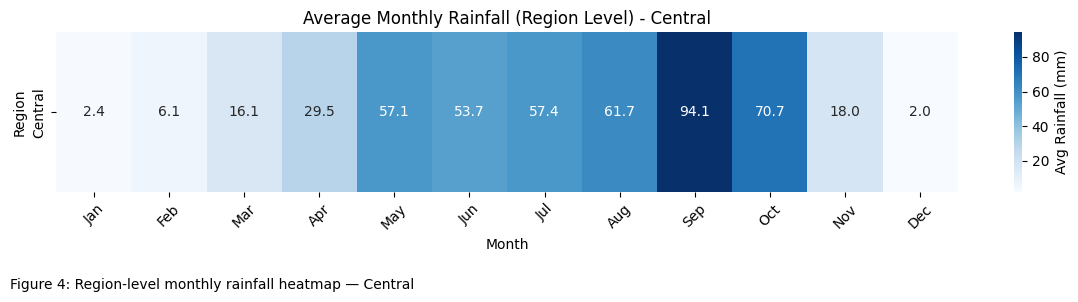

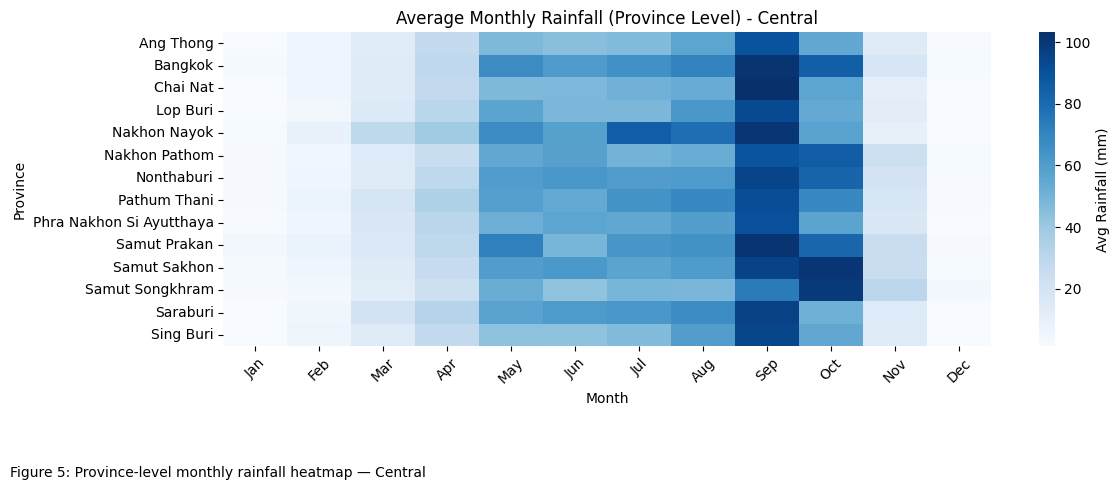

📌 Top 5 Provinces with Highest Rainfall in Central:


,Region_EN,ADM1_EN,rfh_sum
0,Central,Nakhon Nayok,538.66
1,Central,Bangkok,523.76
2,Central,Samut Prakan,518.38
3,Central,Samut Sakhon,513.17
4,Central,Nonthaburi,496.02


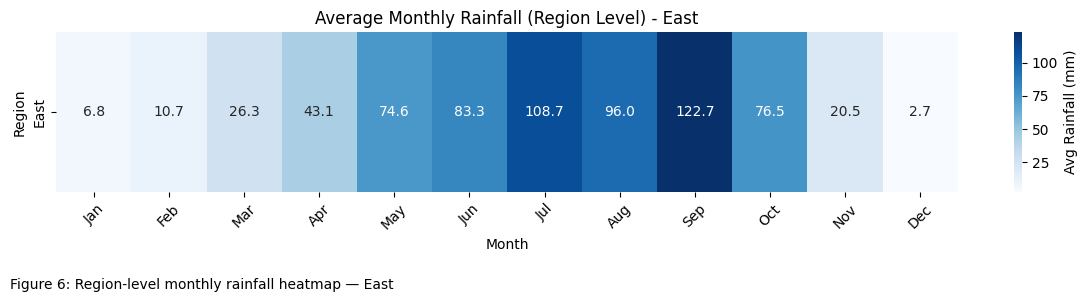

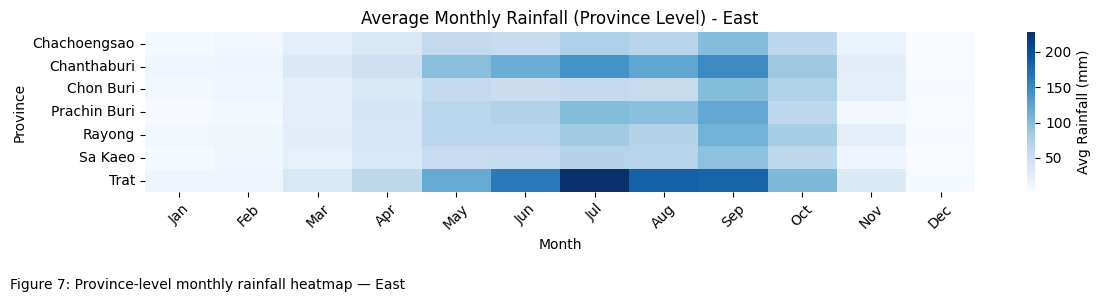

📌 Top 5 Provinces with Highest Rainfall in East:


,Region_EN,ADM1_EN,rfh_sum
0,East,Trat,1139.84
1,East,Chanthaburi,844.71
2,East,Prachin Buri,606.77
3,East,Rayong,587.80
4,East,Chachoengsao,517.63


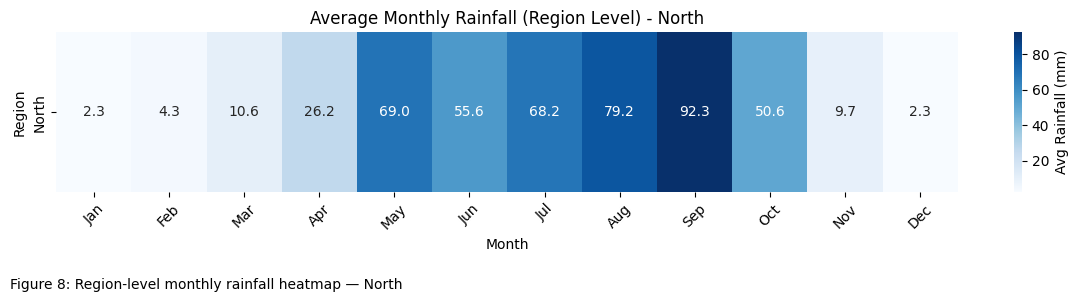

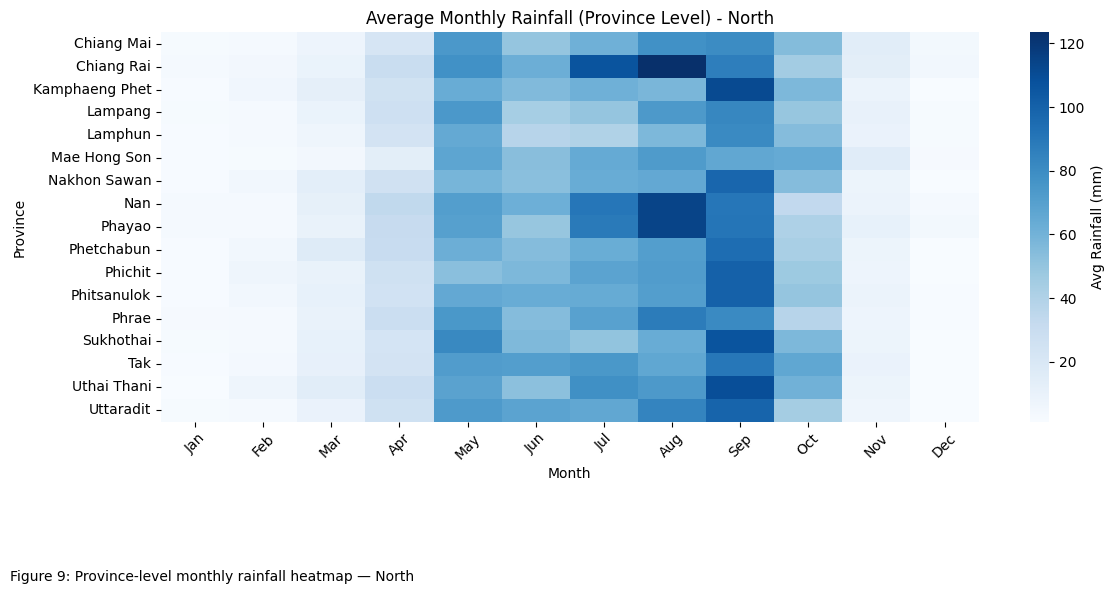

📌 Top 5 Provinces with Highest Rainfall in North:


,Region_EN,ADM1_EN,rfh_sum
0,North,Chiang Rai,568.32
1,North,Nan,526.47
2,North,Phayao,518.20
3,North,Uthai Thani,505.52
4,North,Tak,491.96


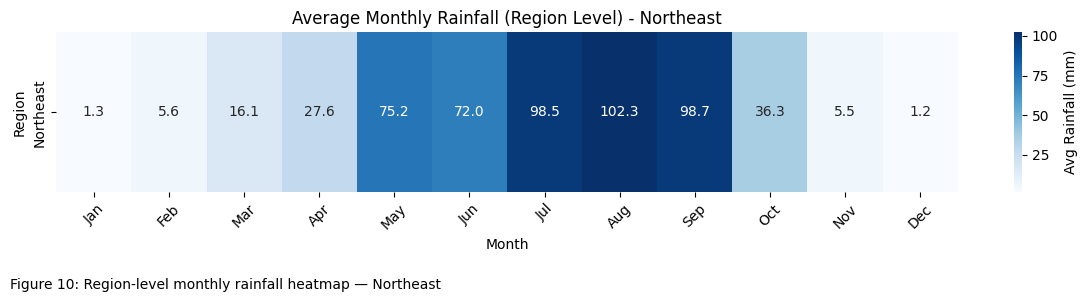

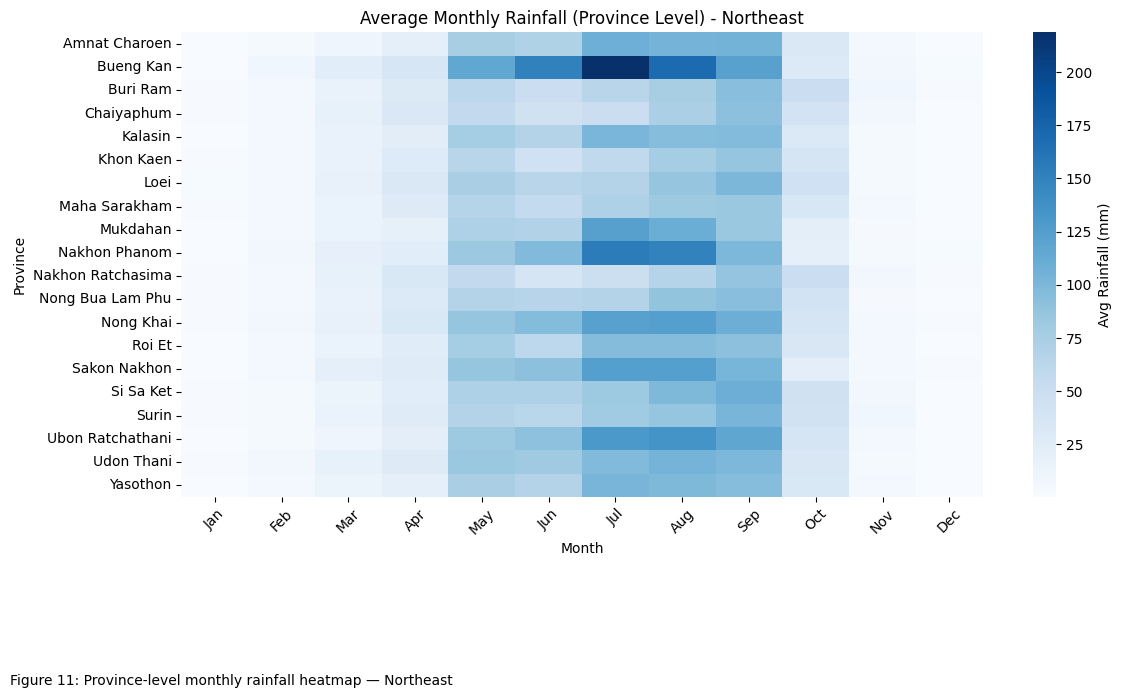

📌 Top 5 Provinces with Highest Rainfall in Northeast:


,Region_EN,ADM1_EN,rfh_sum
0,Northeast,Bueng Kan,888.72
1,Northeast,Nakhon Phanom,665.70
2,Northeast,Nong Khai,641.77
3,Northeast,Ubon Ratchathani,638.85
4,Northeast,Sakon Nakhon,614.06


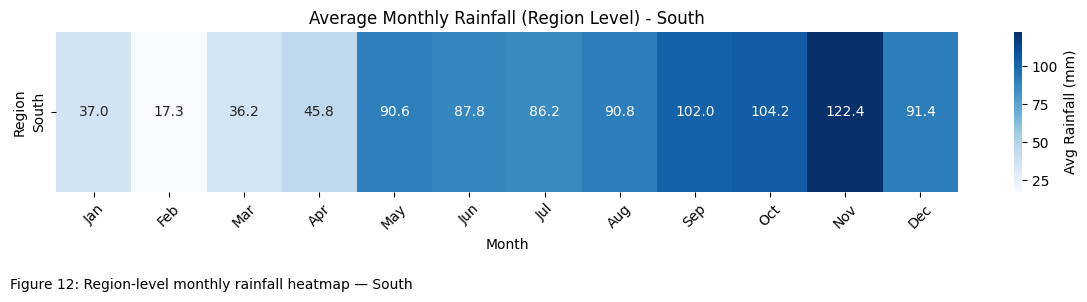

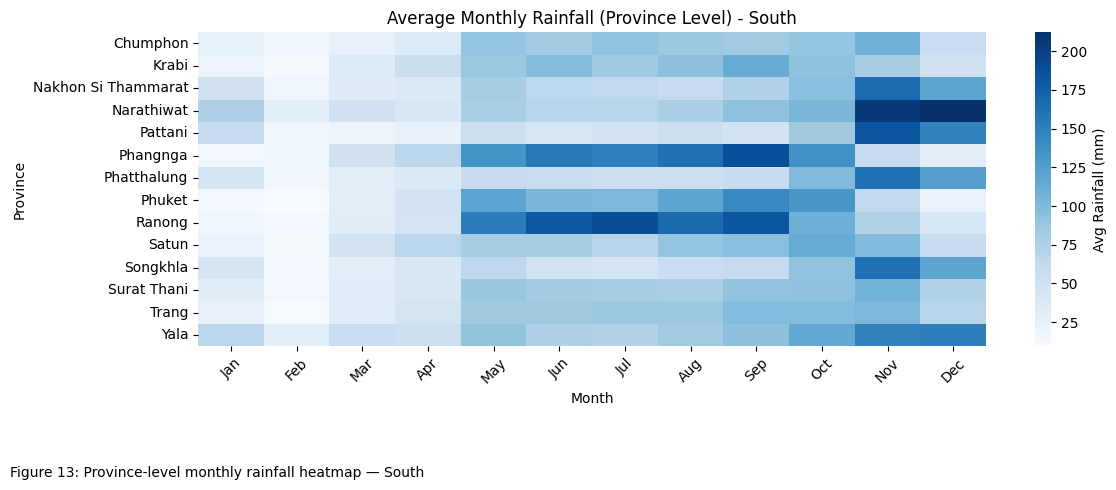

📌 Top 5 Provinces with Highest Rainfall in South:


,Region_EN,ADM1_EN,rfh_sum
0,South,Ranong,1206.48
1,South,Phangnga,1166.15
2,South,Narathiwat,1100.09
3,South,Yala,1040.65
4,South,Phuket,906.72


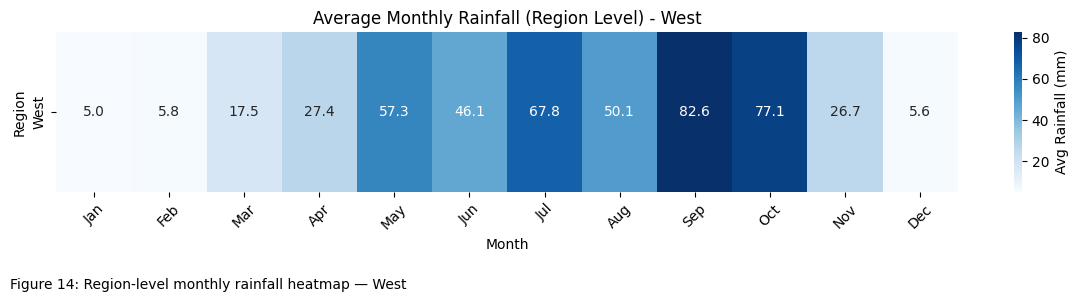

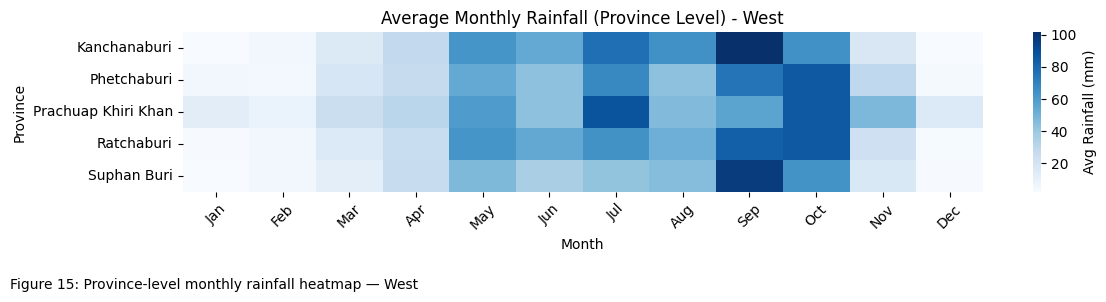

📌 Top 5 Provinces with Highest Rainfall in West:


,Region_EN,ADM1_EN,rfh_sum
0,West,Prachuap Khiri Khan,520.36
1,West,Kanchanaburi,495.61
2,West,Ratchaburi,476.20
3,West,Phetchaburi,457.68
4,West,Suphan Buri,395.33


In [8]:
# =========================================
# 4) Part 2 — Heatmaps + Top5 per Region (refined)
# =========================================
# เตรียม pivot รวมครั้งเดียว
month_order = list(range(1, 13))
region_pivot_all = (
    region_monthly.pivot(index="Region_EN", columns="Month", values="rfh")
                  .reindex(columns=month_order)
)
province_pivot_all = (
    monthly_avg.pivot_table(index="ADM1_EN", columns="Month", values="rfh", aggfunc="mean")
               .reindex(columns=month_order)
)
prov_total = (
    monthly_avg.groupby(["Region_EN", "ADM1_EN"], as_index=False)["rfh"].sum()
    .rename(columns={"rfh": "rfh_sum"})
)

for region in sorted(monthly_avg["Region_EN"].dropna().unique()):
    # Heatmap ภาค
    region_row = region_pivot_all.loc[[region]]
    plt.figure(figsize=(12, 3))
    ax = sns.heatmap(region_row, annot=True, fmt=".1f", cmap="Blues",
                     cbar_kws={'label': 'Avg Rainfall (mm)'})
    ax.set_title(f"Average Monthly Rainfall (Region Level) - {region}")
    ax.set_xlabel("Month"); ax.set_ylabel("Region")
    ax.set_xticklabels([calendar.month_abbr[m] for m in region_row.columns], rotation=45)
    plt.tight_layout()
    add_caption(plt.gcf(), f"Region-level monthly rainfall heatmap — {region}")
    plt.show()

    # Heatmap จังหวัด
    provinces_in_region = (
        monthly_avg.loc[monthly_avg["Region_EN"] == region, "ADM1_EN"]
                   .dropna().unique()
    )
    province_pivot = (
        province_pivot_all.loc[sorted(provinces_in_region)]
        if len(provinces_in_region) else province_pivot_all.iloc[0:0]
    )
    plt.figure(figsize=(12, max(3, 0.35 * max(1, len(province_pivot)))))
    ax = sns.heatmap(province_pivot, annot=False, cmap="Blues",
                     cbar_kws={'label': 'Avg Rainfall (mm)'})
    ax.set_title(f"Average Monthly Rainfall (Province Level) - {region}")
    ax.set_xlabel("Month"); ax.set_ylabel("Province")
    ax.set_xticklabels([calendar.month_abbr[m] for m in province_pivot.columns], rotation=45)
    plt.tight_layout()
    add_caption(plt.gcf(), f"Province-level monthly rainfall heatmap — {region}")
    plt.show()

    # Top 5 provinces ของภาคนั้น (ตาราง)
    top5 = (
        prov_total.loc[prov_total["Region_EN"] == region]
                  .sort_values("rfh_sum", ascending=False)
                  .head(5)
                  .reset_index(drop=True)
    )
    if top5.empty:
        print(f"⚠️ No province data for region: {region}")
    else:
        print(f"📌 Top {min(5, len(top5))} Provinces with Highest Rainfall in {region}:")
        display(top5)



## Part 3.4: ตารางสรุปฤดูมรสุมของแต่ละภาค

In [9]:
# =========================================
# 5) Summary watchlist รายภาค + dict watchlist_by_region
# =========================================
required_cols = {"Region_EN","ADM1_EN","Month","rfh"}
if not required_cols.issubset(set(monthly_avg.columns)):
    raise RuntimeError(f"monthly_avg is missing columns: {sorted(required_cols - set(monthly_avg.columns))}")

WATCH_THRESH = float(WATCH_THRESH) if "WATCH_THRESH" in globals() else 0.6
WATCH_THRESH = min(max(WATCH_THRESH, 0.0), 1.0)

MONTHS = list(range(1, 13))
MONTH_ABBR = {i: calendar.month_abbr[i] for i in MONTHS}
MONTH_NAME = {i: calendar.month_name[i] for i in MONTHS}

def month_abbr_list(nums): return [MONTH_ABBR[int(n)] for n in nums if int(n) in MONTH_ABBR]
def month_range_abbr_list(range_strings):
    out = []
    for s in range_strings:
        if "-" in s:
            a, b = (int(x) for x in s.split("-", 1))
            out.append(f"{MONTH_ABBR.get(a,'')}-{MONTH_ABBR.get(b,'')}")
        else:
            n = int(s)
            out.append(MONTH_ABBR.get(n, ""))
    return out

# ทำ Month ให้เป็นตัวเลข 1..12
mavg2 = monthly_avg.copy()
mavg2["Month"] = pd.to_numeric(mavg2["Month"], errors="coerce")
mavg2 = mavg2[(mavg2["Month"] >= 1) & (mavg2["Month"] <= 12)]
mavg2["Month"] = mavg2["Month"].astype(int)

rain_by_month = (
    mavg2.groupby(["Region_EN", "Month"], as_index=False)["rfh"]
         .mean()
         .sort_values(["Region_EN", "Month"])
)

regions_order = sorted(rain_by_month["Region_EN"].dropna().unique().tolist())
col_watch_nums = f"Watchlist_Months_Num(≥{int(WATCH_THRESH*100)}%Max)"
col_watch_abbr = f"Watchlist_Months_Abbr(≥{int(WATCH_THRESH*100)}%Max)"

summary_rows = []
for reg in regions_order:
    sub = rain_by_month.loc[rain_by_month["Region_EN"] == reg, ["Month", "rfh"]].copy()
    sub = (sub.set_index("Month").reindex(MONTHS).rename_axis("Month").reset_index())
    sub["rfh"] = pd.to_numeric(sub["rfh"], errors="coerce")

    top_rfh = sub["rfh"].max(skipna=True)
    if pd.isna(top_rfh):
        summary_rows.append({
            "Region": reg,
            "Peak_Month_Num": np.nan,
            "Peak_Month": "",
            "Peak_rfh_avg(mm)": np.nan,
            col_watch_nums: "",
            col_watch_abbr: "",
            "Watchlist_Range_Num": "",
            "Watchlist_Range_Abbr": "",
        })
        continue

    # เลือกเดือนพีก (tie-break เดือนเลขน้อย)
    peak_row = sub.sort_values(["rfh", "Month"], ascending=[False, True]).iloc[0]
    top_month_num = int(peak_row["Month"])

    # เดือนที่ >= threshold
    watch_months_num = []
    if float(top_rfh) > 0:
        thr = WATCH_THRESH * float(top_rfh)
        watch_months_num = sub.loc[sub["rfh"] >= thr, "Month"].astype(int).tolist()

    watch_ranges = compress_to_ranges(watch_months_num)

    summary_rows.append({
        "Region": reg,
        "Peak_Month_Num": top_month_num,
        "Peak_Month": MONTH_NAME.get(top_month_num, ""),
        "Peak_rfh_avg(mm)": round(float(top_rfh), 2),
        col_watch_nums: ",".join(str(x) for x in watch_months_num),
        col_watch_abbr: ",".join(month_abbr_list(watch_months_num)),
        "Watchlist_Range_Num": ",".join(watch_ranges),
        "Watchlist_Range_Abbr": ",".join(month_range_abbr_list(watch_ranges)),
    })

summary_df = pd.DataFrame(
    summary_rows,
    columns=[
        "Region",
        "Peak_Month_Num", "Peak_Month", "Peak_rfh_avg(mm)",
        col_watch_nums, col_watch_abbr,
        "Watchlist_Range_Num", "Watchlist_Range_Abbr",
    ]
)
print("สรุปช่วงมรสุมรายภาค (คำนวณจากค่าเฉลี่ยรายเดือนระดับภาค):")
display(summary_df)

watchlist_by_region = (
    summary_df[["Region", "Watchlist_Range_Abbr"]]
    .dropna(subset=["Region"])
    .drop_duplicates("Region")
    .set_index("Region")
    .rename(columns={"Watchlist_Range_Abbr": "range"})
    .to_dict(orient="index")
)
print("watchlist_by_region (sample):", list(watchlist_by_region.items())[:5])


สรุปช่วงมรสุมรายภาค (คำนวณจากค่าเฉลี่ยรายเดือนระดับภาค):


,Region,Peak_Month_Num,Peak_Month,Peak_rfh_avg(mm),Watchlist_Months_Num(≥60%Max),Watchlist_Months_Abbr(≥60%Max),Watchlist_Range_Num,Watchlist_Range_Abbr
0,Central,9,September,94.12,"5,7,8,9,10","May,Jul,Aug,Sep,Oct","5,7-10","May,Jul-Oct"
1,East,9,September,122.73,"5,6,7,8,9,10","May,Jun,Jul,Aug,Sep,Oct",5-10,May-Oct
2,North,9,September,92.26,"5,6,7,8,9","May,Jun,Jul,Aug,Sep",5-9,May-Sep
3,Northeast,8,August,102.32,"5,6,7,8,9","May,Jun,Jul,Aug,Sep",5-9,May-Sep
4,South,11,November,122.38,"5,6,7,8,9,10,11,12","May,Jun,Jul,Aug,Sep,Oct,Nov,Dec",5-12,May-Dec
5,West,9,September,82.59,"5,7,8,9,10","May,Jul,Aug,Sep,Oct","5,7-10","May,Jul-Oct"


watchlist_by_region (sample): [('Central', {'range': 'May,Jul-Oct'}), ('East', {'range': 'May-Oct'}), ('North', {'range': 'May-Sep'}), ('Northeast', {'range': 'May-Sep'}), ('South', {'range': 'May-Dec'})]


# Part 4: วิเคราะห์จังหวัดเสี่ยงน้ำท่วม (Composite Vulnerability)

## Part 4.1: สร้าง Rainfall Watchlist
Step 1: เอาข้อมูล rainfall เฉพาะช่วง watchlist months → รวมฝนต่อจังหวัด

Step 2: รวมข้อมูล จำนวนจุดเสี่ยงน้ำหลากจาก และ พื้นที่น้ำท่วมซ้ำซากจาก (ไร่) Susceptible & Recurrent Flood

Step 3: รวม rainfall_watch + susceptible + recurrent -> Normalize แต่ละ factor (เป็น 0-1 โดยใช้สูตร norm value = (x−min)​/(max−min)

Step 4: รวมคำแนน หาRank จังหวัดภายในแต่ละ region โดยใช้weight Composite score = 0.5rain + 0.3recurrent + 0.2*suscept

In [10]:
# =========================================
# Step 1: สร้าง rfh_watch_pcode หากยังไม่มี  (FIX: ensure Region_EN in base)
# =========================================
if "rfh_watch_pcode" not in globals():
    base = tables["rainfall_cleanes_2000.csv"].copy()
    base = base.rename(columns={
        "ADM1_PCODE":"PCODE","P_CODE":"PCODE",
        "ADM1_NAME":"ADM1_EN","Province":"ADM1_EN","ADM1":"ADM1_EN",
        "month":"Month","MONTH":"Month","MonthNum":"Month","Mon":"Month",
        "RFH":"rfh","rf":"rfh","rain":"rfh","Rainfall":"rfh","RAIN":"rfh",
        "REGION_EN":"Region_EN", "Region":"Region_EN",  # กันชื่อสะกดต่างกัน
    })

    # ---- Ensure PCODE present (map from ADM1_EN if needed)
    if "PCODE" not in base.columns and "ADM1_EN" in base.columns:
        tmp = base[["ADM1_EN","Month","rfh"]].copy()
        tmp["ADM1_EN"] = tmp["ADM1_EN"].astype("string").str.strip()
        base = tmp.merge(ref[["ADM1_EN","PCODE"]], on="ADM1_EN", how="left")
    elif "PCODE" in base.columns:
        base["PCODE"] = base["PCODE"].astype("string").str.strip()
    else:
        raise RuntimeError("[rfh_watch_pcode] rainfall file has neither PCODE nor ADM1_EN to map PCODE.")

    # ---- Clean numeric
    base["Month"] = pd.to_numeric(base["Month"], errors="coerce").astype("Int64")
    base["rfh"]   = pd.to_numeric(base["rfh"], errors="coerce").fillna(0.0)

    # ---- Ensure Region_EN present in base
    if "Region_EN" not in base.columns:
        if "PCODE" in base.columns:
            base = base.merge(ref[["PCODE","Region_EN"]], on="PCODE", how="left")
        if "Region_EN" not in base.columns or base["Region_EN"].isna().all():
            # fallback by ADM1_EN if still missing
            if "ADM1_EN" in tables["rainfall_cleanes_2000.csv"].columns:
                adm_base = tables["rainfall_cleanes_2000.csv"][["ADM1_EN"]].copy()
                adm_base["ADM1_EN"] = adm_base["ADM1_EN"].astype("string").str.strip()
                base = base.merge(
                    ref[["ADM1_EN","Region_EN"]].drop_duplicates(),
                    on="ADM1_EN",
                    how="left"
                )
        # validate again
        if "Region_EN" not in base.columns or base["Region_EN"].isna().any():
            missing = int(base["Region_EN"].isna().sum()) if "Region_EN" in base.columns else "all"
            sample = base.loc[base.get("Region_EN").isna(), ["PCODE","ADM1_EN","Month"]].head(10) if "Region_EN" in base.columns else None
            raise RuntimeError(f"[rfh_watch_pcode] Region_EN still missing ({missing}). Check PCODE/ADM1_EN mapping.\nSample:\n{sample}")

    # ---- Build months_by_region from summary_df or threshold
    def _expand_num_ranges(range_str: str) -> list[int]:
        if not range_str or str(range_str).strip() in {"", "-"}:
            return []
        out = []
        for tok in str(range_str).split(","):
            tok = tok.strip()
            if not tok:
                continue
            if "-" in tok:
                a, b = tok.split("-", 1)
                try:
                    a, b = int(a), int(b)
                except:
                    continue
                out.extend(list(range(min(a, b), max(a, b)+1)))
            else:
                try:
                    out.append(int(tok))
                except:
                    pass
        return [m for m in out if 1 <= m <= 12]

    months_by_region: dict[str, set[int]] = {}

    if "summary_df" in globals():
        # ค้นหาคอลัมน์ช่วงแบบตัวเลขใน summary_df
        cand_num_cols = [c for c in summary_df.columns if "Watchlist" in c and "Num" in c]
        use_col = next((c for c in cand_num_cols if "Watchlist_Months_Num" in c), (cand_num_cols[0] if cand_num_cols else None))
        region_col = "Region" if "Region" in summary_df.columns else ("Region_EN" if "Region_EN" in summary_df.columns else None)

        if use_col and region_col:
            tmp = summary_df[[region_col, use_col]].dropna(subset=[region_col]).drop_duplicates(region_col)
            for _, row in tmp.iterrows():
                reg = str(row[region_col]).strip()
                months_by_region[reg] = set(_expand_num_ranges(row[use_col]))

    if not months_by_region:
        # คำนวณเองจากค่าเฉลี่ยรายภาคโดยใช้ WATCH_THRESH
        WATCH_THRESH = float(WATCH_THRESH) if "WATCH_THRESH" in globals() else 0.6
        WATCH_THRESH = min(max(WATCH_THRESH, 0.0), 1.0)
        region_monthly_calc = (
            base.dropna(subset=["Month"])
                .groupby(["Region_EN","Month"], as_index=False)["rfh"].mean()
        )
        for reg, g in region_monthly_calc.groupby("Region_EN"):
            if g.empty:
                months_by_region[reg] = set()
                continue
            top = g["rfh"].max(skipna=True)
            if pd.isna(top) or top <= 0:
                months_by_region[reg] = set()
                continue
            thr = WATCH_THRESH * float(top)
            sel = g.loc[g["rfh"] >= thr, "Month"].astype(int).tolist()
            months_by_region[reg] = set(m for m in sel if 1 <= m <= 12)

    # ---- Build watch_df (Region_EN, Month) and aggregate rainfall
    watch_pairs = [(reg, int(m)) for reg, ms in months_by_region.items() for m in ms]
    watch_df = pd.DataFrame(watch_pairs, columns=["Region_EN","Month"]).drop_duplicates()

    if watch_df.empty:
        # ไม่มีเดือนเฝ้าระวัง: ให้ rfh_watch เป็น 0 ชัดเจน
        rfh_watch_pcode = (
            base.dropna(subset=["PCODE"])
                .groupby("PCODE", as_index=False)["rfh"].sum()
                .rename(columns={"rfh":"rfh_watch"})
        )
        rfh_watch_pcode["rfh_watch"] = 0.0
    else:
        # >>> จุดที่เคย error: ตอนนี้ base มี Region_EN แน่นอนแล้ว <<<
        rain_watch = base.merge(watch_df, on=["Region_EN","Month"], how="inner").dropna(subset=["PCODE"])
        rfh_watch_pcode = (
            rain_watch.groupby("PCODE", as_index=False)["rfh"]
                      .sum()
                      .rename(columns={"rfh":"rfh_watch"})
        )

    rfh_watch_pcode["PCODE"] = rfh_watch_pcode["PCODE"].astype("string").str.strip()
    print("✅ built rfh_watch_pcode:", rfh_watch_pcode.shape)
    display(rfh_watch_pcode.head(10))

# =========================================
# Step 2: ปัจจัย Susceptible/Recurrent -> รวมเป็น Composite + Rank
# =========================================
# Flood Susceptible
suscept = tables["Flood_Susceptible.csv"].copy()
if "Flood_Susceptible" in suscept.columns and "suscept" not in suscept.columns:
    suscept = suscept.rename(columns={"Flood_Susceptible": "suscept"})
suscept_pcode = sum_by_pcode(suscept, value_col="suscept", ref=ref)

# Recurrent (10y)
recurrent = tables["cleaned_sumflood.csv"].copy()
if "Area_rai" in recurrent.columns and "recurrent10y" not in recurrent.columns:
    recurrent = recurrent.rename(columns={"Area_rai": "recurrent10y"})
recurrent_pcode = sum_by_pcode(recurrent, value_col="recurrent10y", ref=ref)

# รวม + ทำคะแนน
df_all = (
    ref[["PCODE"]]
    .merge(rfh_watch_pcode, on="PCODE", how="left")
    .merge(suscept_pcode,  on="PCODE", how="left")
    .merge(recurrent_pcode, on="PCODE", how="left")
    .merge(ref, on="PCODE", how="left")  # เติมชื่อจังหวัด/ภาค
)

for c in ["rfh_watch", "suscept", "recurrent10y"]:
    if c not in df_all.columns:
        df_all[c] = 0
    df_all[c] = pd.to_numeric(df_all[c], errors="coerce").fillna(0.0)

df_all["rfh_watch_norm"]    = minmax_norm(df_all["rfh_watch"])
df_all["recurrent10y_norm"] = minmax_norm(df_all["recurrent10y"])
df_all["suscept_norm"]      = minmax_norm(df_all["suscept"])

W_RAIN, W_RECUR, W_SUS = 0.5, 0.3, 0.2
df_all["Composite_score"] = (
    W_RAIN * df_all["rfh_watch_norm"]
    + W_RECUR * df_all["recurrent10y_norm"]
    + W_SUS  * df_all["suscept_norm"]
)

df_all["Rank_in_region"] = (
    df_all.groupby("Region_EN")["Composite_score"]
          .rank(ascending=False, method="dense")
          .astype(int)
)

cols_show = [
    "Region_EN","ADM1_EN","PCODE",
    "rfh_watch","rfh_watch_norm",
    "recurrent10y","recurrent10y_norm",
    "suscept","suscept_norm",
    "Composite_score","Rank_in_region"
]
df_all = (
    df_all[cols_show]
          .sort_values(["Region_EN","Composite_score"], ascending=[True, False])
          .reset_index(drop=True)
)

print("📌 TABLE: Province Watchlist (Composite Score, by province)")
display(df_all.head(120))


✅ built rfh_watch_pcode: (57, 2)


,PCODE,rfh_watch
0,TH10,735320.09
1,TH11,173771.13
2,TH12,190018.86
3,TH13,213378.45
4,TH14,379108.16
5,TH15,178120.47
6,TH16,285582.84
7,TH17,158299.18
8,TH18,164406.32
9,TH19,328028.11


📌 TABLE: Province Watchlist (Composite Score, by province)


,Region_EN,ADM1_EN,PCODE,rfh_watch,rfh_watch_norm,recurrent10y,recurrent10y_norm,suscept,suscept_norm,Composite_score,Rank_in_region
0,Central,Bangkok,TH10,735320.09,0.74,165431.00,0.08,271,0.07,0.41,1
1,Central,Phra Nakhon Si Ayutthaya,TH14,379108.16,0.38,1091126.00,0.53,713,0.22,0.39,2
2,Central,Lop Buri,TH16,285582.84,0.29,547000.00,0.26,802,0.25,0.27,3
3,Central,Saraburi,TH19,328028.11,0.33,317901.00,0.15,728,0.22,0.25,4
4,Central,Nakhon Pathom,TH73,200962.81,0.20,442731.00,0.21,574,0.17,0.20,5
...,...,...,...,...,...,...,...,...,...,...,...
72,West,Suphan Buri,TH72,244686.35,0.24,932151.00,0.45,936,0.29,0.32,1
73,West,Kanchanaburi,TH71,363618.55,0.36,104229.00,0.05,1048,0.33,0.26,2
74,West,Ratchaburi,TH70,262026.97,0.26,186351.00,0.09,970,0.30,0.22,3
75,West,Phetchaburi,TH76,221951.50,0.22,9983.00,0.00,673,0.20,0.15,4


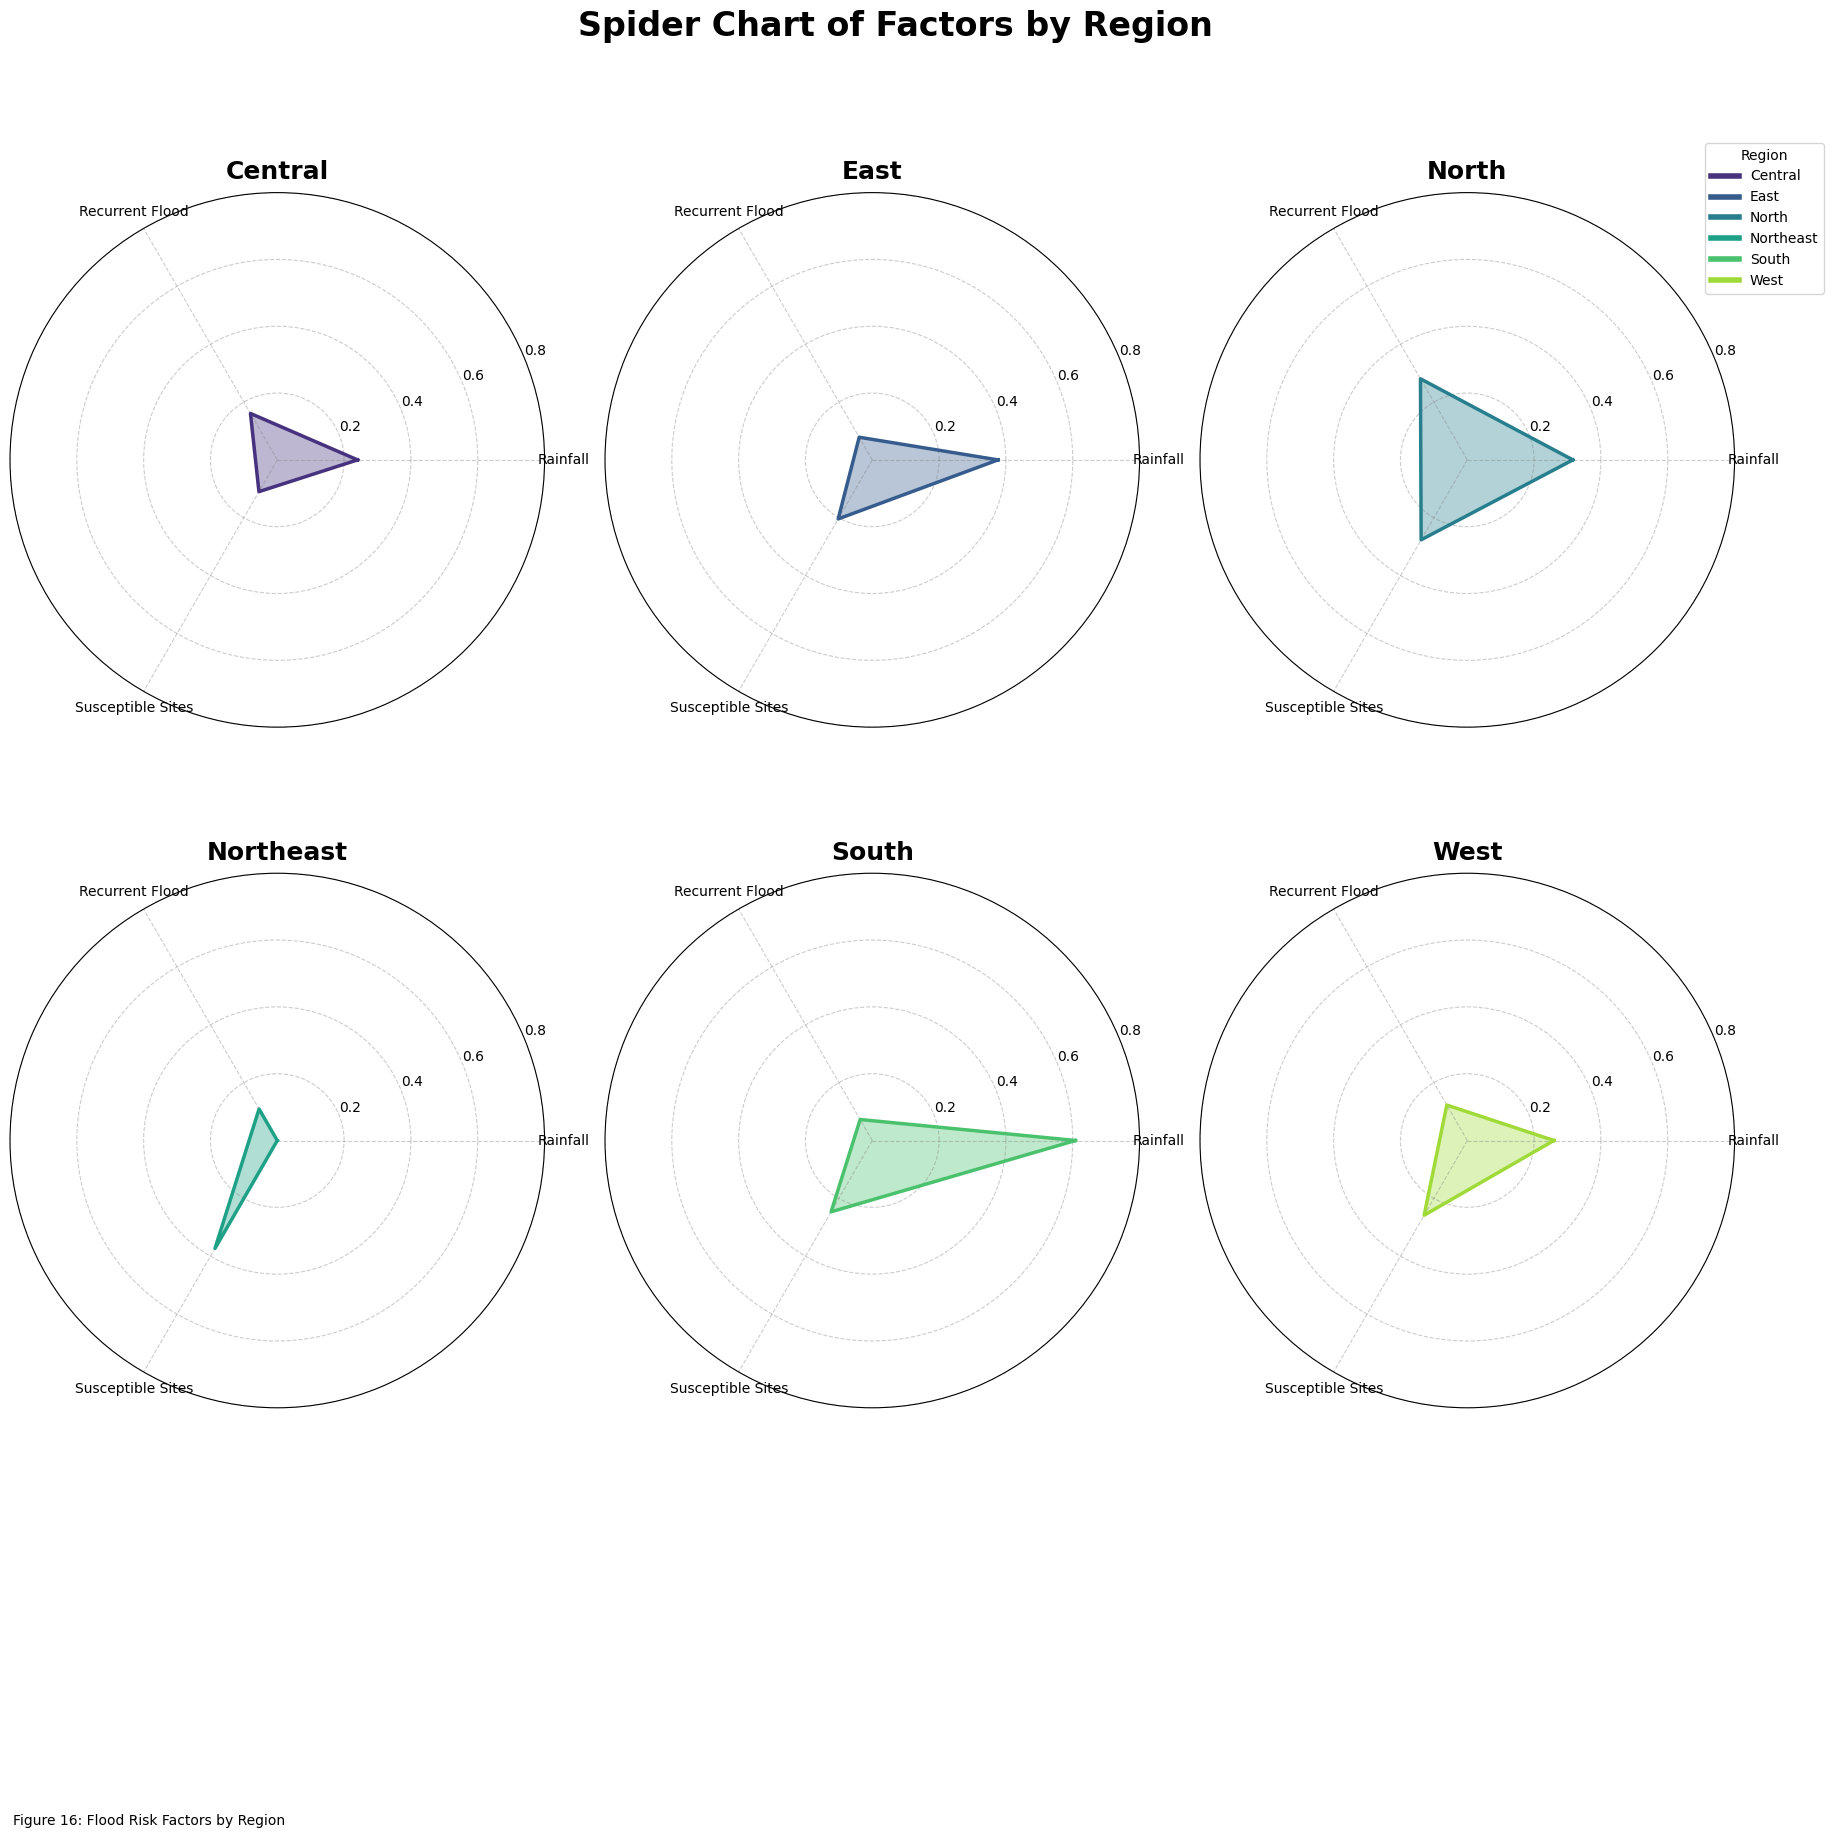

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn for color palettes

def plot_radar_regions_grid(df_all):
    factors = ["rfh_watch_norm", "recurrent10y_norm", "suscept_norm"]
    factor_labels = ["Rainfall", "Recurrent Flood", "Susceptible Sites"]

    # ค่าเฉลี่ยของแต่ละภาค
    region_avg = df_all.groupby("Region_EN")[factors].mean()
    regions = region_avg.index.tolist()

    # เตรียมแกนเรดาร์
    N = len(factors)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    # เตรียม subplot 2 แถว × 3 คอลัมน์
    ncols = 3
    nrows = int(np.ceil(len(regions)/ncols))
    # Adjust figsize for better readability
    fig, axes = plt.subplots(nrows, ncols, figsize=(18,18), subplot_kw=dict(polar=True))

    # ทำให้ axes เป็น array เดียว
    axes = axes.flatten()

    # Use a professional color palette
    colors = sns.color_palette('viridis', len(regions))

    for i, (reg, row) in enumerate(region_avg.iterrows()):
        ax = axes[i]
        values = row.tolist()
        values += values[:1]

        ax.plot(angles, values, linewidth=2.5, linestyle='solid', label=reg, color=colors[i])
        ax.fill(angles, values, alpha=0.35, color=colors[i])
        # Customize grid and ticks
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(factor_labels, fontsize=10) # Bold labels
        ax.set_yticks([0.2, 0.4, 0.6, 0.8])
        ax.set_ylim(0,0.8)
        ax.set_title(reg, fontsize=18, va='bottom', weight='bold') # Bold title and adjust position

        # Customize grid lines
        ax.xaxis.grid(True, color='gray', linestyle='--', alpha=0.4)
        ax.yaxis.grid(True, color='gray', linestyle='--', alpha=0.4)

    # ซ่อนกราฟที่เกินออกมา
    for i in range(len(region_avg), len(axes)):
        fig.delaxes(axes[i])

    plt.suptitle("Spider Chart of Factors by Region", fontsize=24, y=1.02, weight='bold') # Adjusted suptitle position and added bold
    plt.tight_layout()
    # เพิ่มพื้นที่แนวตั้งและแนวนอนระหว่าง subplots
    plt.subplots_adjust(hspace=1.5, wspace=0.6, top=0.95)

    # Add a single legend for all subplots
    # Create custom handles for the legend
    custom_lines = [plt.Line2D([0], [0], color=colors[i], lw=4) for i in range(len(regions))]
    fig.legend(custom_lines, regions, loc='upper right', bbox_to_anchor=(1.02, 0.95), title="Region", fontsize=10)


    add_caption(fig, "Flood Risk Factors by Region")
    plt.show()

# run
plot_radar_regions_grid(df_all)

## Part 4.2: แสดงกราฟแท่งแสดง Top 10 จังหวัดในแต่ละภาค
เพื่อแสดงจังหวัดที่มีค่า Composite Score สูงที่สุด → ใช้เพื่อดูว่าจังหวัดไหน "เปราะบาง" หรือ "เสี่ยงน้ำท่วม" มากสุดในภาคนั้น ๆ

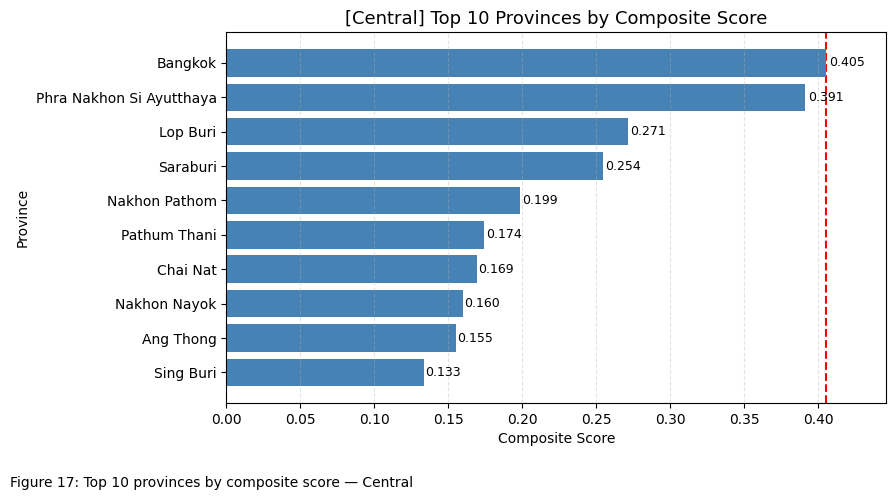

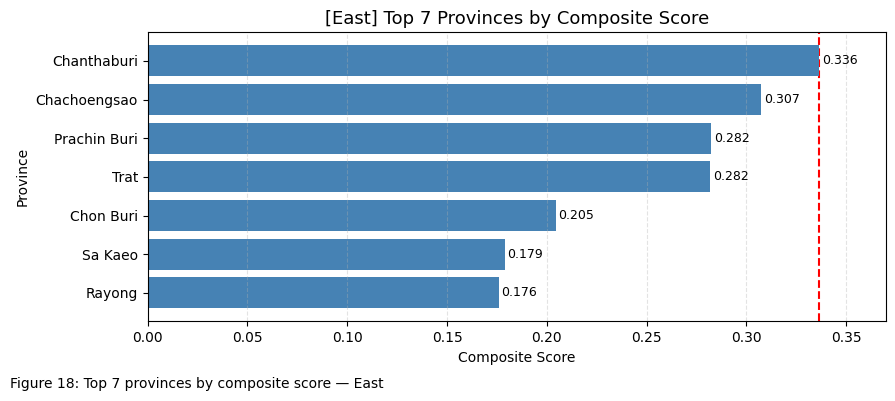

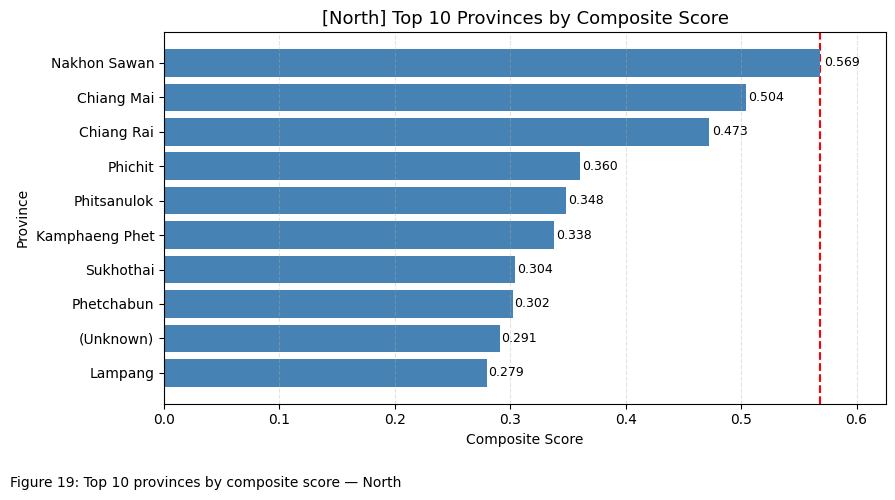

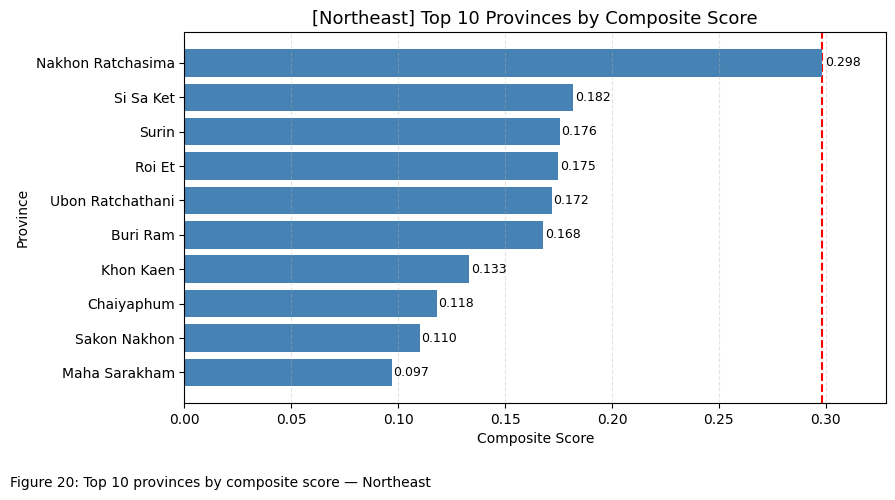

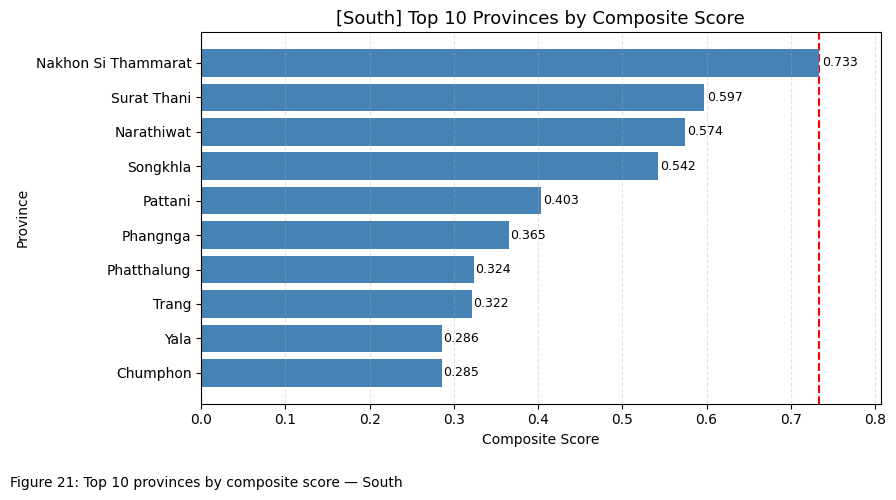

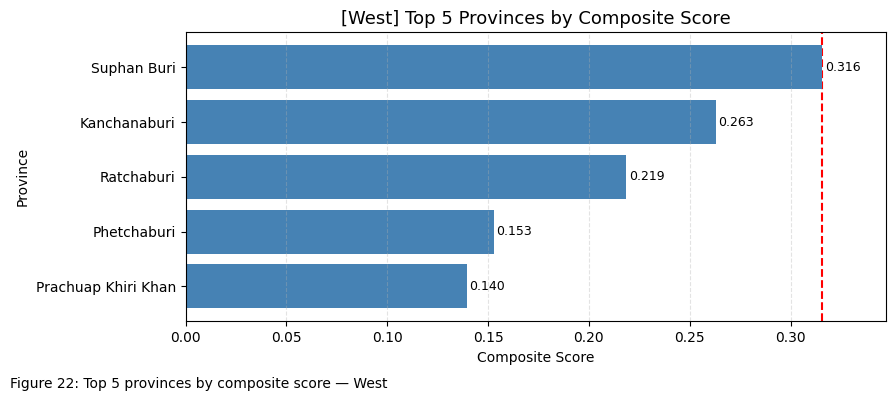

In [12]:
# =========================================
# Charts: Top-N per region by Composite
# =========================================
TOP_N = 10
for reg, sub in df_all.groupby("Region_EN", sort=False):
    plot_df = sub[["ADM1_EN","Composite_score"]].copy()
    plot_df["ADM1_EN"] = sanitize_names(plot_df["ADM1_EN"])
    plot_df["Composite_score"] = pd.to_numeric(plot_df["Composite_score"], errors="coerce").fillna(0.0)

    topn = plot_df.sort_values("Composite_score", ascending=False).head(TOP_N)
    if topn.empty:
        print(f"[{reg}] No data to plot.");
        continue

    topn_plot = topn.iloc[::-1].reset_index(drop=True)
    fig, ax = plt.subplots(figsize=(9, max(4, 0.5 * len(topn_plot))))
    bars = ax.barh(topn_plot["ADM1_EN"].tolist(),
                   topn_plot["Composite_score"].tolist(),
                   color="steelblue")

    ax.set_title(f"[{reg}] Top {min(TOP_N, len(topn_plot))} Provinces by Composite Score", fontsize=13)
    ax.set_xlabel("Composite Score"); ax.set_ylabel("Province")
    ax.grid(axis="x", linestyle="--", alpha=0.35)

    ymax = float(topn_plot["Composite_score"].max()) or 1.0
    ax.axvline(ymax, color="red", linestyle="--", zorder=0)
    ax.set_xlim(0, ymax * 1.10)

    for rect in bars:
        v = rect.get_width()
        ax.text(v * 1.005, rect.get_y() + rect.get_height()/2, f"{v:.3f}",
                va="center", ha="left", fontsize=9)

    plt.tight_layout()
    add_caption(fig, f"Top {min(TOP_N, len(topn_plot))} provinces by composite score — {reg}")
    plt.show()


# Optional: Overall Summary Charts (All Regions)



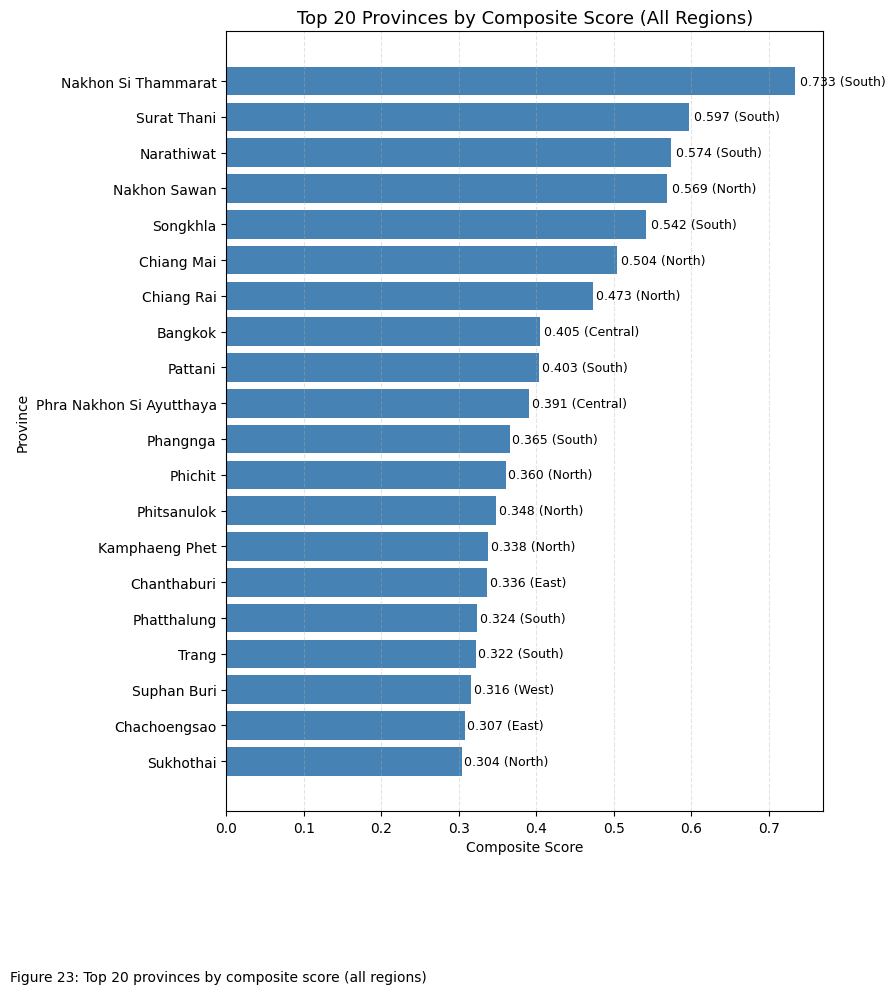

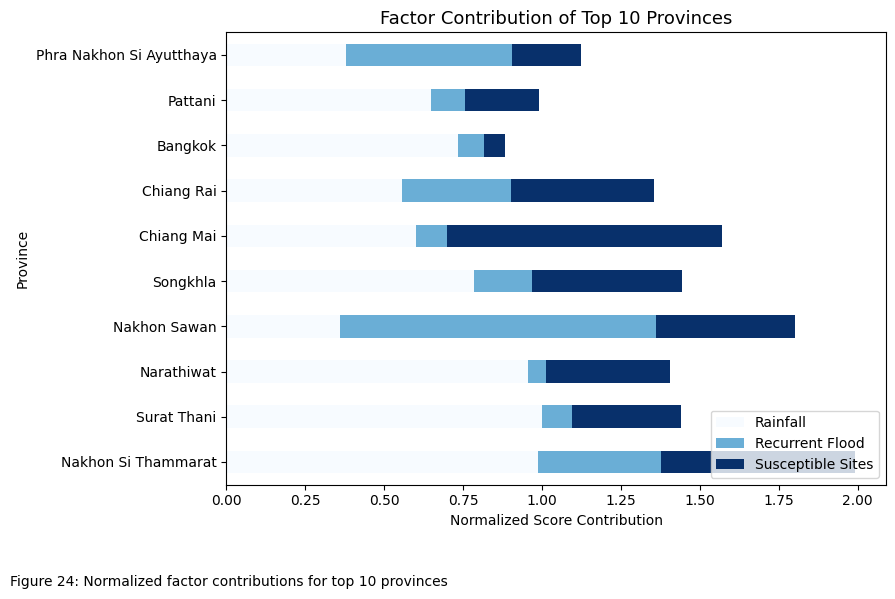

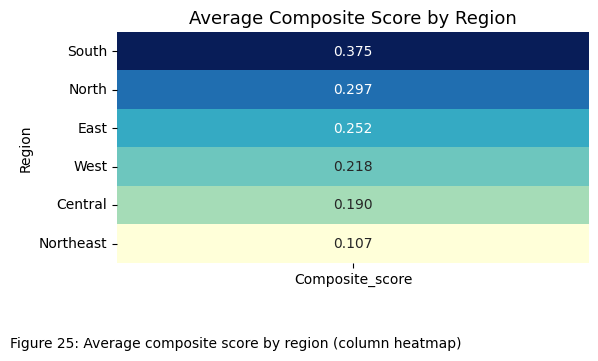

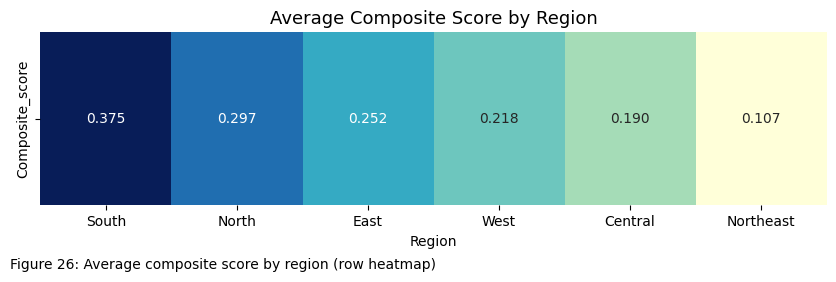

In [13]:


# =========================================
# 9) Overall Summary Charts (All Regions)
# =========================================
# ---- Top-N all provinces (barh) ----
TOP_ALL = 20
top_all = (
    df_all[["ADM1_EN","Region_EN","Composite_score"]]
    .sort_values("Composite_score", ascending=False)
    .head(TOP_ALL)
    .iloc[::-1]  # กลับลำดับ เพื่อให้ค่ามากสุดอยู่บนใน barh
)

fig, ax = plt.subplots(figsize=(9, max(6, 0.5 * len(top_all))))
bars = ax.barh(top_all["ADM1_EN"], top_all["Composite_score"], color="steelblue")

ax.set_title(f"Top {min(TOP_ALL, len(top_all))} Provinces by Composite Score (All Regions)", fontsize=13)
ax.set_xlabel("Composite Score"); ax.set_ylabel("Province")
ax.grid(axis="x", linestyle="--", alpha=0.35)

# แสดงคะแนนและชื่อภาคท้ายแท่ง
for rect, reg in zip(bars, top_all["Region_EN"]):
    v = rect.get_width()
    ax.text(v * 1.01,
            rect.get_y() + rect.get_height()/2,
            f"{v:.3f} ({reg})",
            va="center", ha="left", fontsize=9)

plt.tight_layout()
add_caption(fig, f"Top {min(TOP_ALL, len(top_all))} provinces by composite score (all regions)")
plt.show()

# ---- Stacked factors for Top-K provinces ----
TOP_STACK = 10
sub = (
    df_all.sort_values("Composite_score", ascending=False)
          .head(TOP_STACK)
          .set_index("ADM1_EN")[["rfh_watch_norm","recurrent10y_norm","suscept_norm"]]
          .rename(columns={
              "rfh_watch_norm":   "Rainfall",
              "recurrent10y_norm":"Recurrent Flood",
              "suscept_norm":     "Susceptible Sites"
          })
)

ax = sub.plot(kind="barh", stacked=True, figsize=(9, 6), colormap="Blues")
ax.set_title(f"Factor Contribution of Top {min(TOP_STACK, len(sub))} Provinces", fontsize=13)
ax.set_xlabel("Normalized Score Contribution"); ax.set_ylabel("Province")
ax.legend(loc="lower right")
plt.tight_layout()
add_caption(plt.gcf(), f"Normalized factor contributions for top {min(TOP_STACK, len(sub))} provinces")
plt.show()

# ---- Average Composite Score by Region (heatmap: column vector) ----
region_summary = (
    df_all.groupby("Region_EN")["Composite_score"]
          .mean()
          .sort_values(ascending=False)
          .to_frame(name="Composite_score")  # Series -> DataFrame (N x 1)
)

plt.figure(figsize=(6, max(3, 0.6*len(region_summary))))
ax = sns.heatmap(region_summary, annot=True, fmt=".3f", cmap="YlGnBu", cbar=False)
ax.set_title("Average Composite Score by Region", fontsize=13)
ax.set_xlabel("")  # ให้กราฟดูคลีน
ax.set_ylabel("Region")
plt.tight_layout()
add_caption(plt.gcf(), "Average composite score by region (column heatmap)")
plt.show()

# ---- Same metric, transposed (heatmap: 1 x N) ----
region_summary_T = region_summary.T  # 1 แถว x N ภาค
plt.figure(figsize=(max(6, 1.4*len(region_summary_T.columns)), 2.8))
ax = sns.heatmap(region_summary_T, annot=True, fmt=".3f", cmap="YlGnBu", cbar=False)
ax.set_title("Average Composite Score by Region", fontsize=13)
ax.set_xlabel("Region"); ax.set_ylabel("")  # ซ่อนชื่อแกนแถว
plt.tight_layout()
add_caption(plt.gcf(), "Average composite score by region (row heatmap)")
plt.show()
